In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, confusion_matrix,
                            classification_report, roc_curve, auc)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Load the data
data = pd.read_csv('data (1).csv')

# Display basic information
print("Dataset Shape:", data.shape)
print("\nFirst 5 rows:")
print(data.head())
print("\nData Information:")
print(data.info())
print("\nSummary Statistics:")
print(data.describe())
print("\nMissing Values:")
print(data.isnull().sum())
print("\nClass Distribution (Fail):")
print(data['fail'].value_counts())
print("Failure Rate:", data['fail'].mean() * 100, "%")

Dataset Shape: (944, 10)

First 5 rows:
   footfall  tempMode  AQ  USS  CS  VOC  RP  IP  Temperature  fail
0         0         7   7    1   6    6  36   3            1     1
1       190         1   3    3   5    1  20   4            1     0
2        31         7   2    2   6    1  24   6            1     0
3        83         4   3    4   5    1  28   6            1     0
4       640         7   5    6   4    0  68   6            1     0

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 944 entries, 0 to 943
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   footfall     944 non-null    int64
 1   tempMode     944 non-null    int64
 2   AQ           944 non-null    int64
 3   USS          944 non-null    int64
 4   CS           944 non-null    int64
 5   VOC          944 non-null    int64
 6   RP           944 non-null    int64
 7   IP           944 non-null    int64
 8   Temperature  944 non-null    

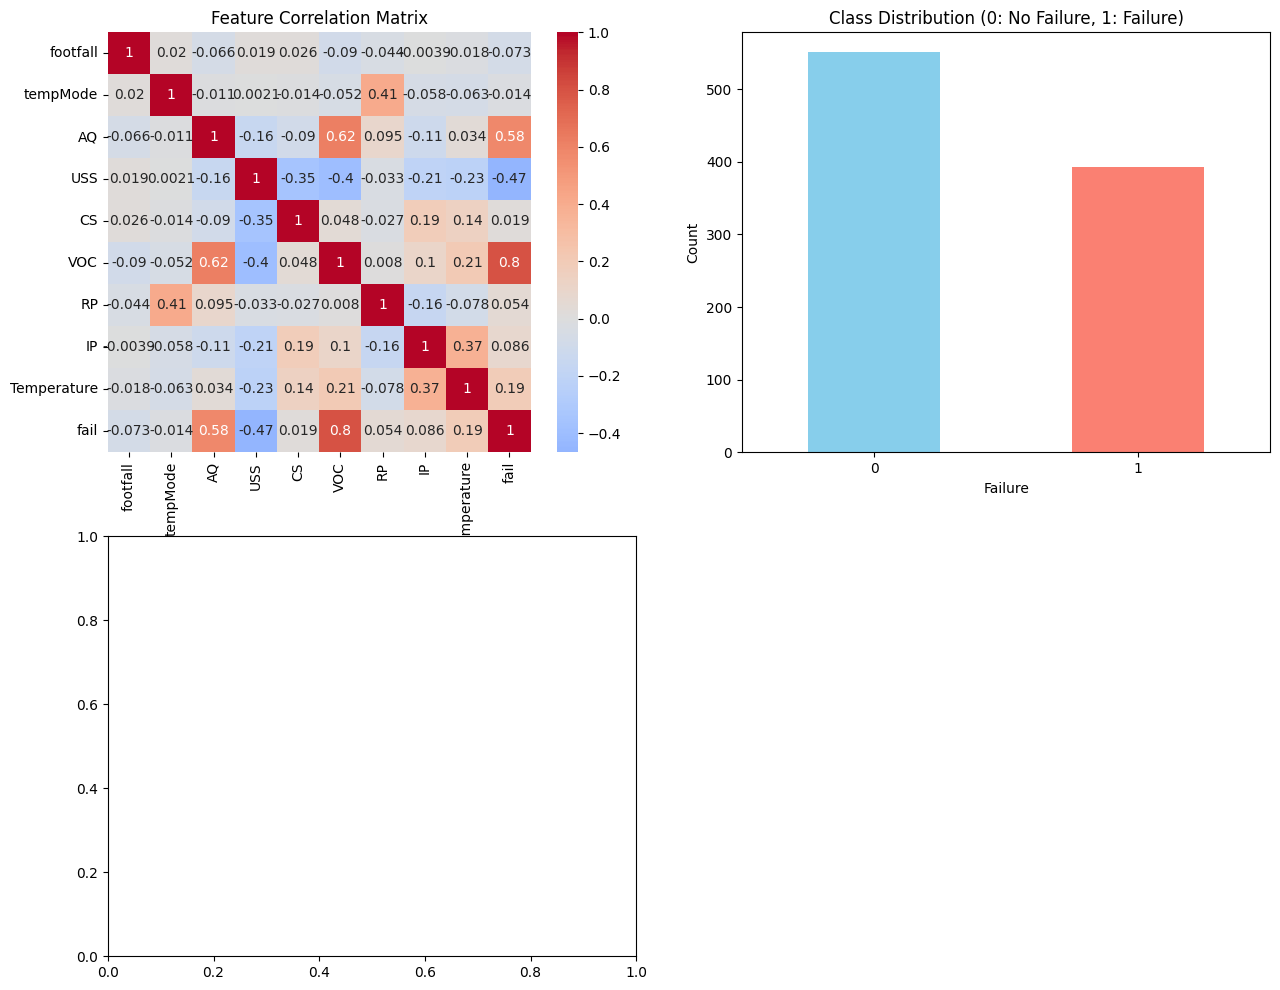

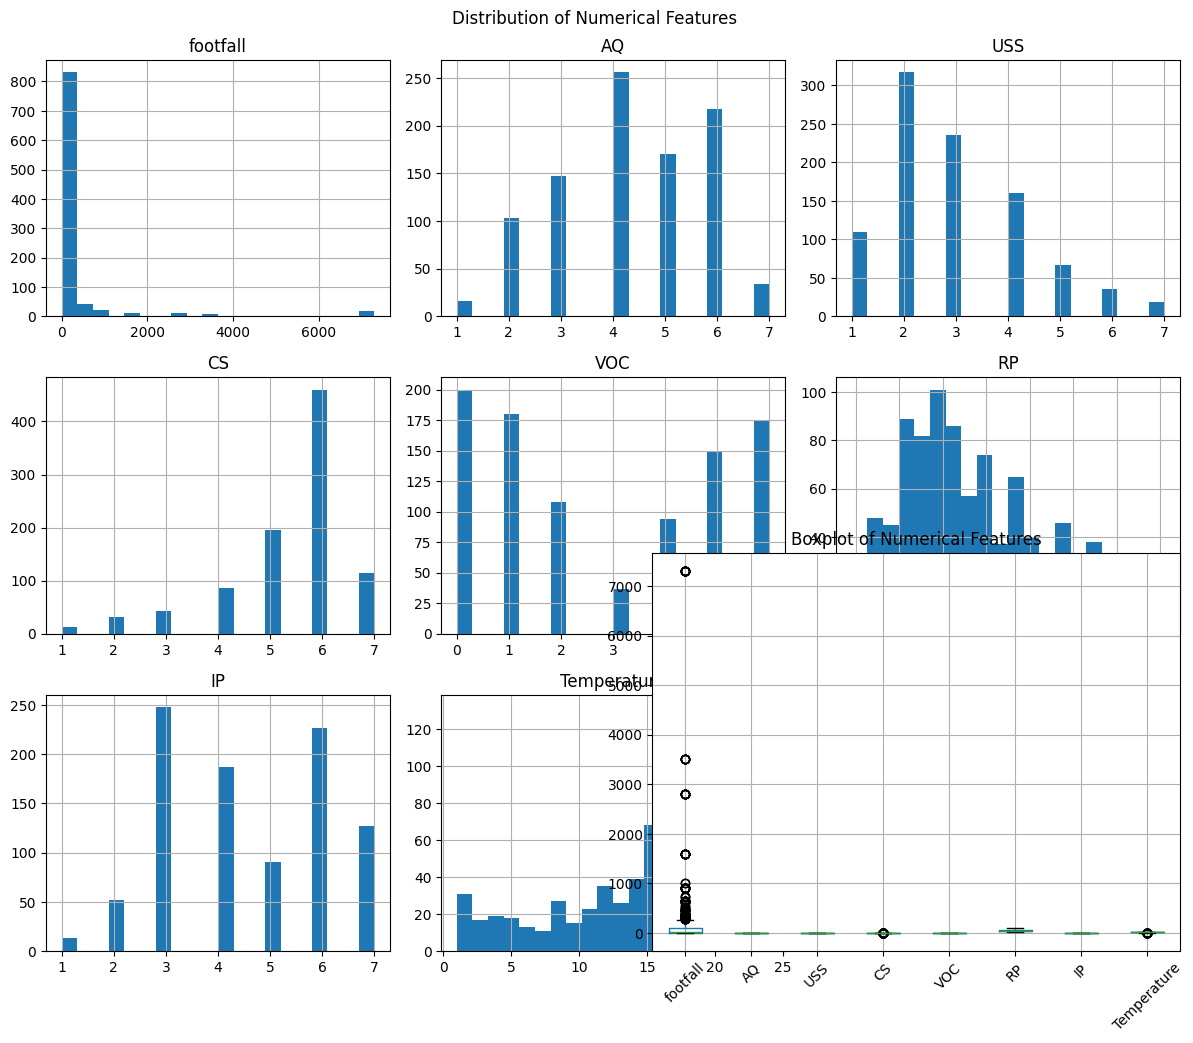

In [ ]:
# Exploratory Data Analysis
plt.figure(figsize=(15, 12))

# 1. Correlation heatmap
plt.subplot(2, 2, 1)
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')

# 2. Class distribution
plt.subplot(2, 2, 2)
data['fail'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution (0: No Failure, 1: Failure)')
plt.xlabel('Failure')
plt.ylabel('Count')
plt.xticks(rotation=0)

# 3. Distribution of numerical features
plt.subplot(2, 2, 3)
numeric_features = ['footfall', 'AQ', 'USS', 'CS', 'VOC', 'RP', 'IP', 'Temperature']
data[numeric_features].hist(bins=20, figsize=(12, 10))
plt.suptitle('Distribution of Numerical Features')
plt.tight_layout()

# 4. Boxplots to identify outliers
plt.subplot(2, 2, 4)
data.boxplot(column=numeric_features)
plt.xticks(rotation=45)
plt.title('Boxplot of Numerical Features')

plt.tight_layout()
plt.show()

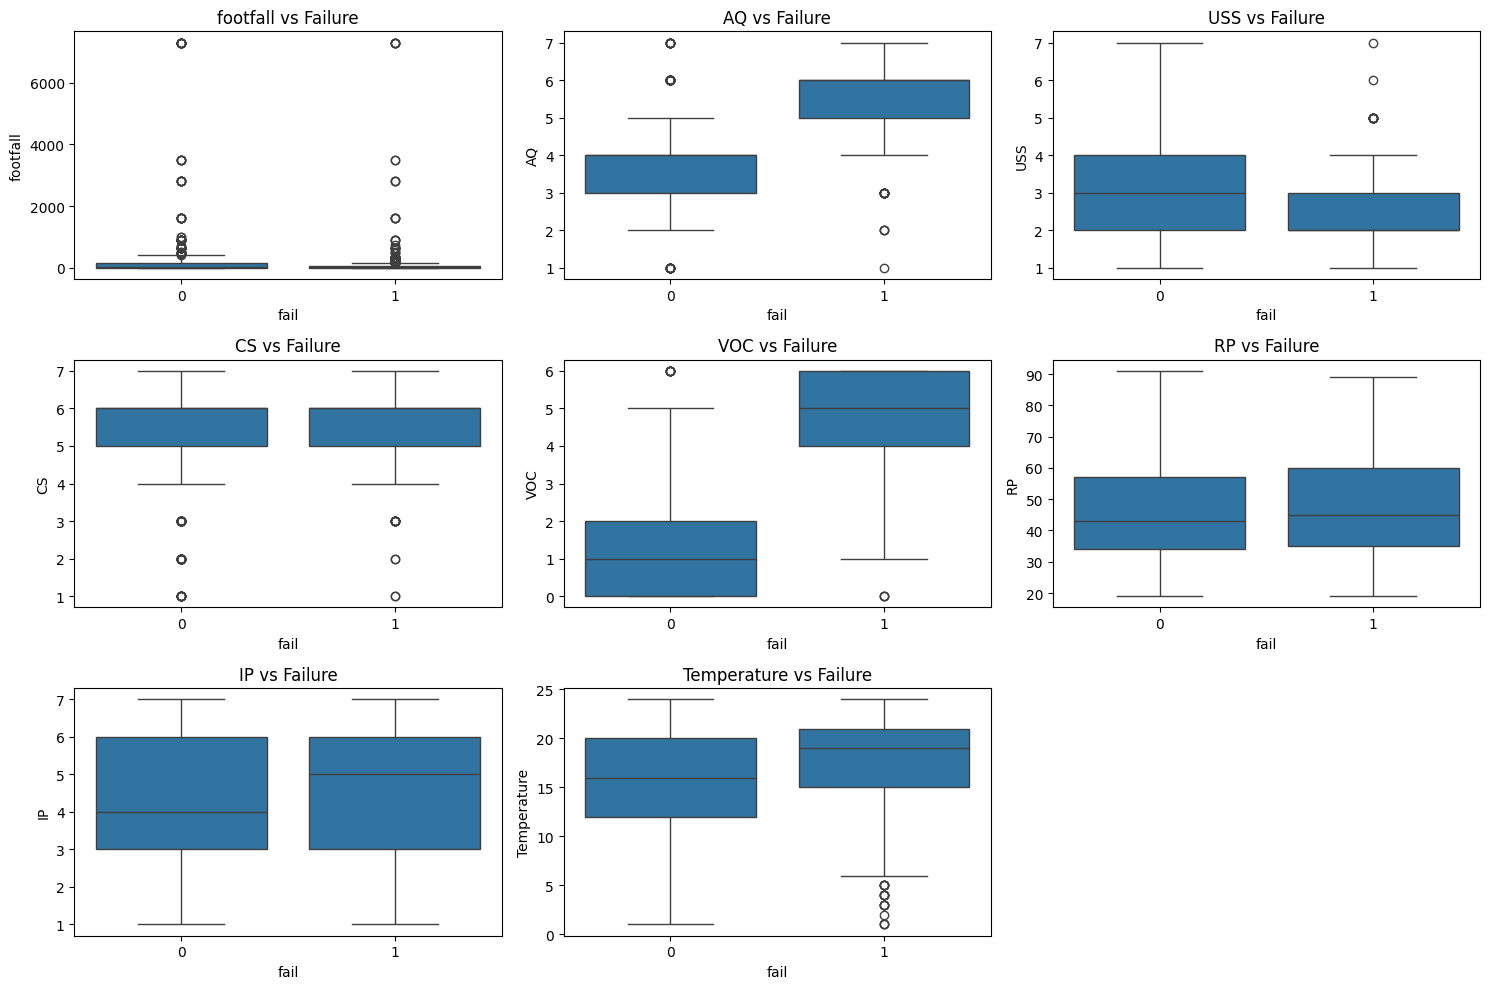

<Figure size 1000x600 with 0 Axes>

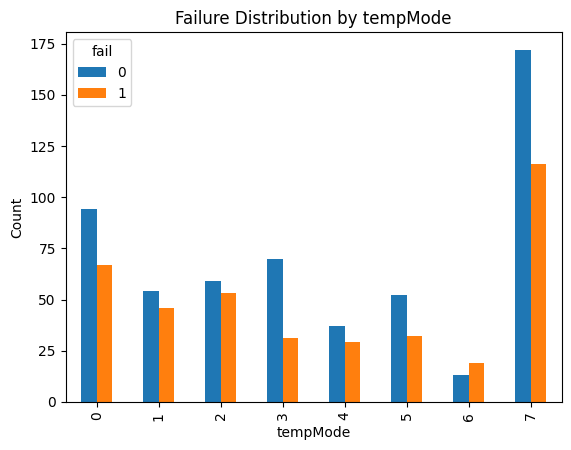

In [ ]:
# Feature-target relationships
plt.figure(figsize=(15, 10))

for i, feature in enumerate(numeric_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='fail', y=feature, data=data)
    plt.title(f'{feature} vs Failure')

plt.tight_layout()
plt.show()

# Categorical feature analysis
categorical_features = ['tempMode']
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    pd.crosstab(data[feature], data['fail']).plot(kind='bar')
    plt.title(f'Failure Distribution by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()

In [ ]:
# Prepare data for modeling
X = data.drop('fail', axis=1)
y = data['fail']

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Original class distribution:", np.bincount(y))
print("Resampled class distribution:", np.bincount(y_resampled))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Original class distribution: [551 393]
Resampled class distribution: [551 551]


In [ ]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

# Train and evaluate models
results = {}

for name, model in models.items():
    # Train model
    if name in ['SVM', 'K-Nearest Neighbors']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
print("Model Performance Comparison:")
print(results_df.round(4))

Model Performance Comparison:
                     Accuracy  Precision  Recall  F1-Score  ROC-AUC
Logistic Regression    0.9321     0.9279  0.9364    0.9321   0.9749
Random Forest          0.9276     0.9196  0.9364    0.9279   0.9792
Gradient Boosting      0.9186     0.9182  0.9182    0.9182   0.9844
SVM                    0.9502     0.9381  0.9636    0.9507   0.9848
K-Nearest Neighbors    0.9276     0.9123  0.9455    0.9286   0.9676
XGBoost                0.9321     0.9204  0.9455    0.9327   0.9803


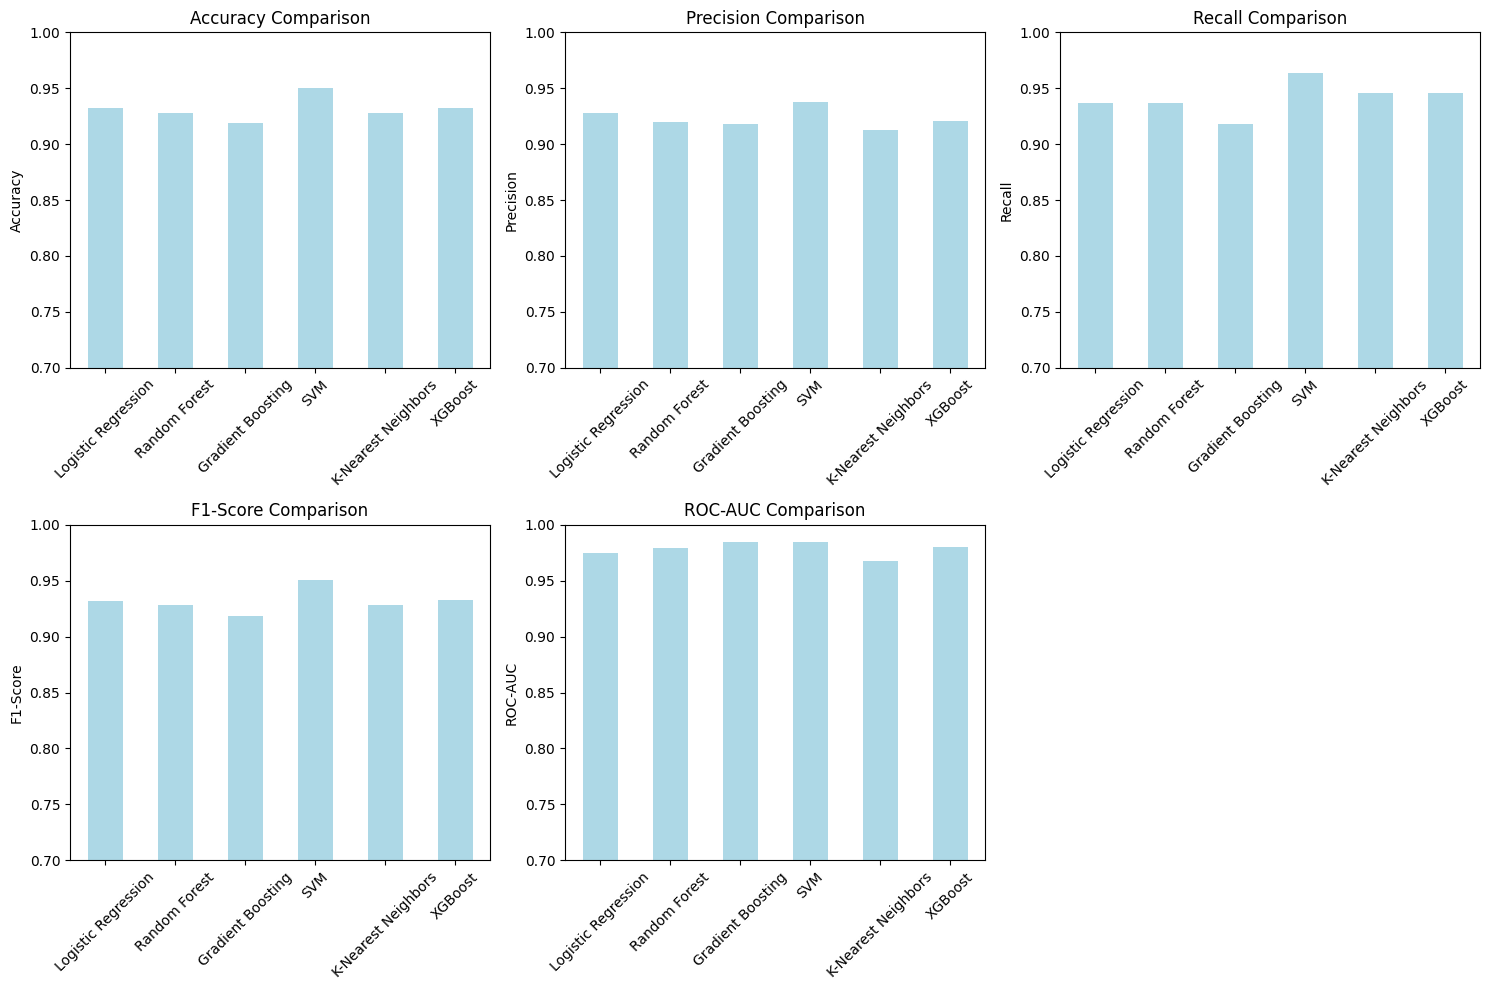

In [ ]:
# Plot model performance comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
plt.figure(figsize=(15, 10))

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    results_df[metric].plot(kind='bar', color='lightblue')
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.ylim(0.7, 1.0)

plt.tight_layout()
plt.show()

In [ ]:
# Hyperparameter tuning for the best model (Random Forest)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Train best model
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)
y_prob_best = best_rf.predict_proba(X_test)[:, 1]

# Evaluate best model
print("\nBest Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("Precision:", precision_score(y_test, y_pred_best))
print("Recall:", recall_score(y_test, y_pred_best))
print("F1-Score:", f1_score(y_test, y_pred_best))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_best))

Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation score: 0.9137776884063886

Best Model Performance:
Accuracy: 0.9276018099547512
Precision: 0.9196428571428571
Recall: 0.9363636363636364
F1-Score: 0.9279279279279279
ROC-AUC: 0.9798525798525799


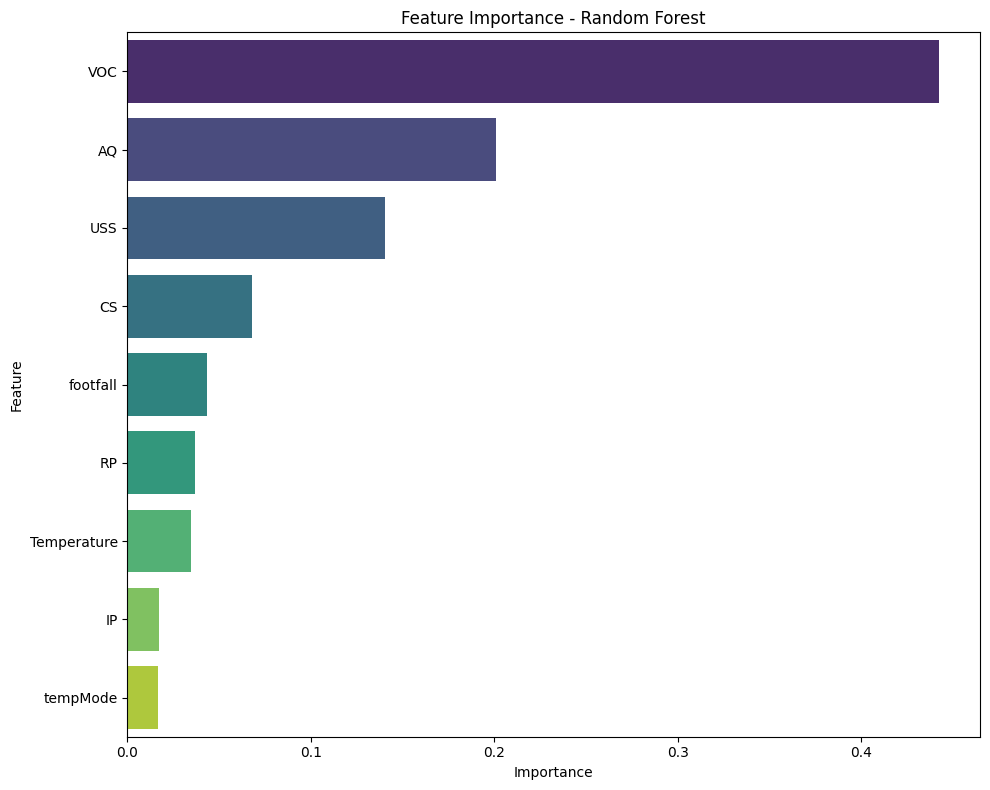

Top 5 Most Important Features:
    Feature  Importance
5       VOC    0.442449
2        AQ    0.200707
3       USS    0.140421
4        CS    0.068139
0  footfall    0.043218


In [ ]:
# Feature importance analysis
feature_importance = best_rf.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance - Random Forest')
plt.tight_layout()
plt.show()

print("Top 5 Most Important Features:")
print(importance_df.head())

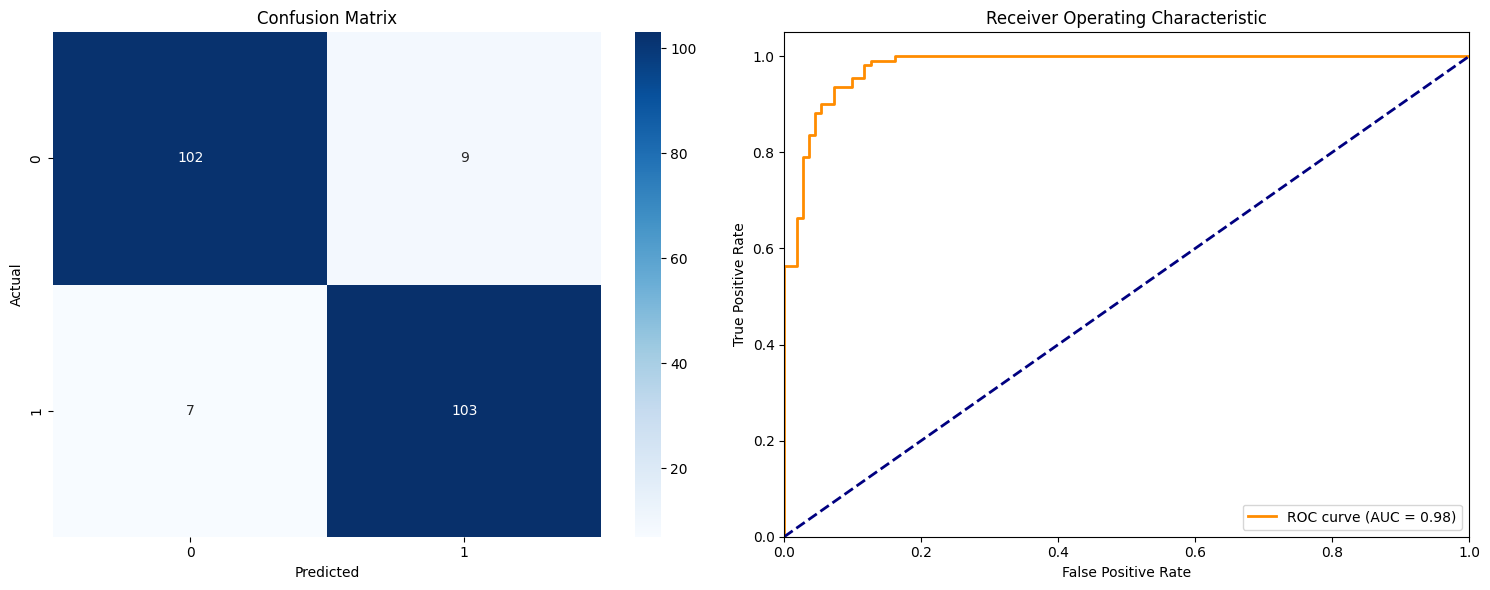


Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       111
           1       0.92      0.94      0.93       110

    accuracy                           0.93       221
   macro avg       0.93      0.93      0.93       221
weighted avg       0.93      0.93      0.93       221



In [ ]:
# Confusion matrix and ROC curve for best model
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_best)
roc_auc = auc(fpr, tpr)
ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic')
ax2.legend(loc="lower right")

plt.tight_layout()
plt.show()

# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_best))

Final Model Comparison:
                     Accuracy  Precision  Recall  F1-Score  ROC-AUC
Logistic Regression    0.9321     0.9279  0.9364    0.9321   0.9749
Random Forest          0.9276     0.9196  0.9364    0.9279   0.9792
Gradient Boosting      0.9186     0.9182  0.9182    0.9182   0.9844
SVM                    0.9502     0.9381  0.9636    0.9507   0.9848
K-Nearest Neighbors    0.9276     0.9123  0.9455    0.9286   0.9676
XGBoost                0.9321     0.9204  0.9455    0.9327   0.9803
Tuned Random Forest    0.9276     0.9196  0.9364    0.9279   0.9799


<Figure size 1200x800 with 0 Axes>

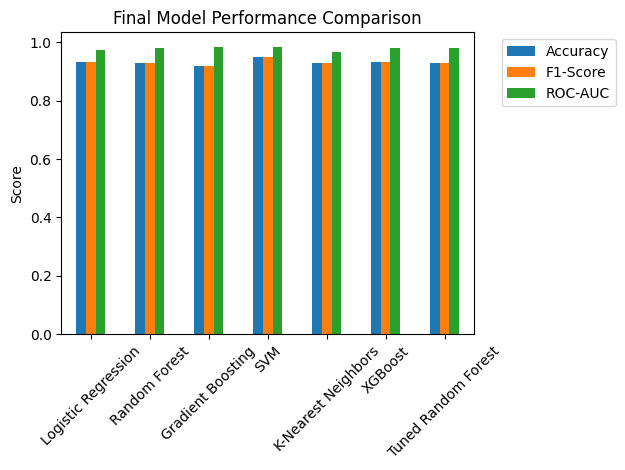

In [ ]:
# Final model comparison
final_comparison = results_df.copy()
final_comparison.loc['Tuned Random Forest'] = {
    'Accuracy': accuracy_score(y_test, y_pred_best),
    'Precision': precision_score(y_test, y_pred_best),
    'Recall': recall_score(y_test, y_pred_best),
    'F1-Score': f1_score(y_test, y_pred_best),
    'ROC-AUC': roc_auc_score(y_test, y_prob_best)
}

print("Final Model Comparison:")
print(final_comparison.round(4))

# Plot final comparison
plt.figure(figsize=(12, 8))
final_comparison[['Accuracy', 'F1-Score', 'ROC-AUC']].plot(kind='bar')
plt.title('Final Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()